# MNIST on the Healpix sphere

In this notebook we show how to use NNhealpix to reproduce a classic NN test on the Healpix sphere: the recognition of handwritten digits from the MNIST dataset.

In [1]:
# import tensorflow.keras
from tensorflow.keras.datasets import mnist
# import tensorflow.keras.layers
from nnhealpix.projections import img2healpix, img2healpix_planar
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
from tensorflow.keras.utils import to_categorical
import nnhealpix.layers
from tensorflow.keras import backend as K
import tensorflow as tf
# K.common.set_image_dim_ordering('th')
tf.random.set_seed(7) # in order to reproduce the same results

### Download the MNIST data and take a subset of it

In [2]:
Ntrain = 10000
Ntest = 100
(X_train_temp, y_train), (X_test_temp, y_test) = mnist.load_data()
X_train_temp = X_train_temp[0:Ntrain]
y_train = y_train[0:Ntrain]
X_test_temp = X_test_temp[0:Ntest]
y_test = y_test[0:Ntest]
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(y_train.shape)

(10000, 10)


### Project the dataset on healpix map

The projection is done at on the same portion of the Healpix map for all the cases.

In [3]:
nside = 16
X_train_hp = img2healpix_planar(X_train_temp, nside, 90, 0, 100, 100)
X_test_hp = img2healpix_planar(X_test_temp, nside, 90, 0, 100, 100)

Here we plot an image as an example: first as a 2D flat image, then as a Healpix full-sky map with the digit projected along the Equator.

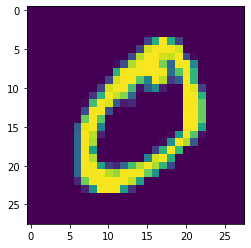

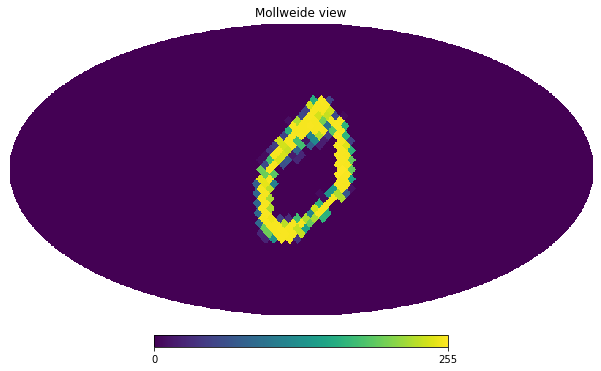

In [4]:
plt.imshow(X_train_temp[1])
hp.mollview(X_train_hp[1])

### Build the train, test, and validation sets

In [5]:
seed = 7
np.random.seed(seed)

In [6]:
X_train = X_train_hp.reshape(X_train_hp.shape[0], len(X_train_hp[0]), 1).astype('float32')
X_test = X_test_hp.reshape(X_test_hp.shape[0], len(X_train_hp[0]), 1).astype('float32')

In [7]:
X_train = X_train / 255
X_test = X_test / 255
num_classes = y_train.shape[1]
shape = (len(X_train_hp[0]), 1)
print(X_train.shape, shape, y_train.shape)

(10000, 3072, 1) (3072, 1) (10000, 10)


### Build a NN architecture

In [8]:
inputs = tf.keras.layers.Input(shape)
x = nnhealpix.layers.ConvNeighbours(nside, filters=32, kernel_size=9)(inputs)
x = tf.keras.layers.Activation('relu')(x)
x = nnhealpix.layers.MaxPooling(nside, 8)(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128)(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dense(num_classes)(x)
out = tf.keras.layers.Activation('softmax')(x)
model = tf.keras.models.Model(inputs=inputs, outputs=out)
model.compile(loss=tf.keras.losses.mse, optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072, 1)]         0         
_________________________________________________________________
order_map (OrderMap)         (None, 27648, 1)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 3072, 32)          288       
_________________________________________________________________
activation (Activation)      (None, 3072, 32)          0         
_________________________________________________________________
order_map_1 (OrderMap)       (None, 3072, 32)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 768, 32)           0         
_________________________________________________________________
dropout (Dropout)            (None, 768, 32)           0     

### …and train the network

In [9]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=12, batch_size=200, verbose=1)
scores = model.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

Train on 10000 samples, validate on 100 samples
Epoch 1/12
10000/10000 [==============================] - 3s 252us/sample - loss: 0.0311 - accuracy: 0.7922 - val_loss: 0.0145 - val_accuracy: 0.8900
Epoch 2/12
10000/10000 [==============================] - 2s 158us/sample - loss: 0.0132 - accuracy: 0.9128 - val_loss: 0.0107 - val_accuracy: 0.9400
Epoch 3/12
10000/10000 [==============================] - 2s 159us/sample - loss: 0.0108 - accuracy: 0.9318 - val_loss: 0.0081 - val_accuracy: 0.9300
Epoch 4/12
10000/10000 [==============================] - 2s 152us/sample - loss: 0.0087 - accuracy: 0.9464 - val_loss: 0.0083 - val_accuracy: 0.9400
Epoch 5/12
10000/10000 [==============================] - 2s 150us/sample - loss: 0.0073 - accuracy: 0.9551 - val_loss: 0.0059 - val_accuracy: 0.9600
Epoch 6/12
10000/10000 [==============================] - 2s 150us/sample - loss: 0.0059 - accuracy: 0.9650 - val_loss: 0.0057 - val_accuracy: 0.9700
Epoch 7/12
10000/10000 [============================

### Application of the same NN architecture to planar images

We apply standard NN to the same dataset to compare the performance. Example adapted from https://keras.io/examples/mnist_cnn/

In [10]:
batch_size = 128
num_classes = 10
epochs = 12

In [11]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [12]:
seed = 7
np.random.seed(seed)

In [13]:
y_test.shape

(10000,)

In [14]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [15]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [16]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
scores = model.evaluate(x_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))


Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 5s 79us/sample - loss: 0.2414 - accuracy: 0.9268 - val_loss: 0.0556 - val_accuracy: 0.9816
Epoch 2/12
60000/60000 [==============================] - 5s 76us/sample - loss: 0.0836 - accuracy: 0.9753 - val_loss: 0.0359 - val_accuracy: 0.9875
Epoch 3/12
60000/60000 [==============================] - 4s 74us/sample - loss: 0.0611 - accuracy: 0.9809 - val_loss: 0.0308 - val_accuracy: 0.9902
Epoch 4/12
60000/60000 [==============================] - 4s 74us/sample - loss: 0.0490 - accuracy: 0.9852 - val_loss: 0.0285 - val_accuracy: 0.9912
Epoch 5/12
60000/60000 [==============================] - 4s 74us/sample - loss: 0.0399 - accuracy: 0.9877 - val_loss: 0.0298 - val_accuracy: 0.9917
Epoch 6/12
60000/60000 [==============================] - 4s 74us/sample - loss: 0.0368 - accuracy: 0.9884 - val_loss: 0.0305 - val_accuracy: 0.9907
Epoch 7/12
60000/60000 [==============================] 

# Performances are comparable!



